In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
from skimage.draw import polygon2mask
from scipy import ndimage
from PIL import Image
from src.preprocessing import process_image, process_video
from skimage.color import label2rgb
from skimage.morphology import label
from IPython.display import display, clear_output
from skimage.measure import regionprops
from concurrent.futures import ThreadPoolExecutor
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import time
import concurrent.futures



In [2]:
label_video = process_video('images/cheese_gel.avi', threshold=0.3, skip_size=60)

In [3]:
print(label_video.shape)

(4, 1002, 1002)


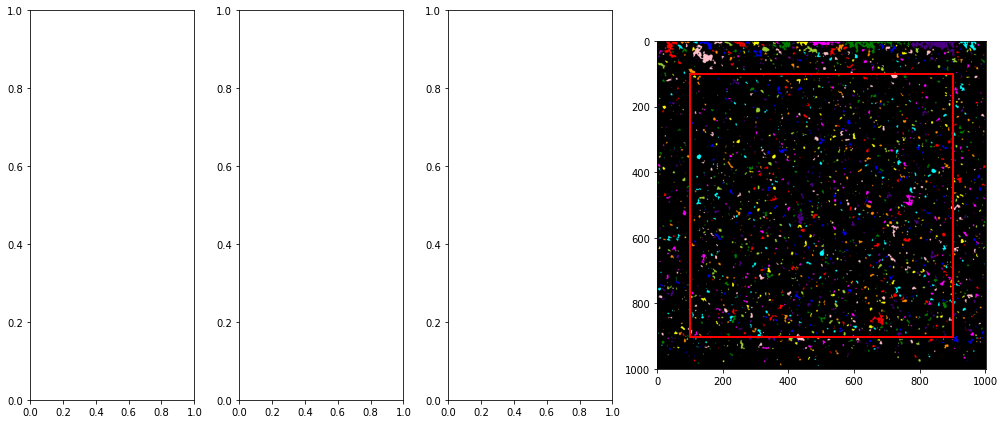

In [4]:
fig, ax = plt.subplots(1,4, figsize=(14,6), gridspec_kw={'width_ratios': [1, 1, 1, 2]})
fig.subplots_adjust(wspace=0.4)
plt.tight_layout()
# colors = np.array(mpl.mcolors.get_cmap('Blues')(np.linspace(0.2, 1, 10)))

n_colors = 8
b_colors = cm.Blues(np.linspace(0.2, 1, n_colors))
g_colors = cm.Greens(np.linspace(0.2, 1, n_colors))
r_colors = cm.Reds(np.linspace(0.2, 1, n_colors))

def process_label_image(p,label_image):
    # label_image = label_image[200:700,200:700]

    L = 100 # Maximum distances to consider
    M = label_image.shape[0] - L

    label_image_bounded = np.zeros(label_image.shape, dtype=int)
    cluster_num = 1
    for region in regionprops(label_image):
        minr, minc, maxr, maxc = region.bbox
        if (minr > L+1) and (minc > L+1) and (maxr < M-1) and (maxc < M-1):
            pixel_coordinates = region.coords
            label_image_bounded[pixel_coordinates[:,0],  pixel_coordinates[:,1]] =  cluster_num
            cluster_num += 1

    bx = (L, M, M, L, L)
    by = (L, L, M, M, L)
    ax[3].plot(bx, by, '-r')
    ax[3].imshow(label2rgb(label_image, bg_label=0))
    curr_image = label_image_bounded

    F = np.zeros(L+1)
    G = np.zeros(L+1)
    times = []
    for cluster in range(1, curr_image.max()+1):
        ref_cluster = curr_image == cluster
        rem_clusters = label_image * np.invert(ref_cluster)
        D = ndimage.distance_transform_edt(ref_cluster==0)
        # print("D", D.max(),D.min(),D)
        f = np.zeros(L+1)
        g = np.zeros(L+1)
        
        K = [D <= x for x in range(L+1)]

        f = np.array([np.count_nonzero(K[i] * rem_clusters) for i in range(L+1)])
        g = np.array([np.count_nonzero(K[i]) for i in range(L+1)])
 
        F += f
        G += g
    
    F = F / curr_image.max()
    G = G / curr_image.max()
    ax[0].plot(F, color=b_colors[p//3])
    ax[0].set_xlabel('r')
    ax[0].set_ylabel('area overlap')

    ax[1].plot(F/G, color=r_colors[p//3])
    ax[1].set_xlabel('r')
    ax[1].set_ylabel('fractional area overlap')

    ax[2].plot(F[1:]-F[:-1], color=g_colors[p//3])
    ax[2].set_xlabel('r')
    ax[2].set_ylabel('curve overlap')
    clear_output(wait = True)
    display(fig)

# create a thread pool with 4 worker threads
executor = ThreadPoolExecutor(max_workers=4)

# call the function for each label image with threads
for p, label_image in enumerate(label_video):
    executor.submit(process_label_image, p, label_image)


plt.show()

In [5]:
K = [D <= x for x in np.arange(0,L+1) ]
f = np.array([np.count_nonzero(K[i] * rem_clusters) for i in range(L+1)])


NameError: name 'L' is not defined

In [ ]:
# print(sum(times)/len(times))
# print(curr_image.max())
# print(len(rem_clusters[0]))
# print(len(K[0,0]))

1002
